In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer

pd.set_option('display.max_columns', None)

In [2]:
path_interim = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/interim/'

caratteristiche = pd.read_excel(path_interim+'caratteristiche.xlsx')
costi = pd.read_excel(path_interim+'costi.xlsx')
efficienza_energetica = pd.read_excel(path_interim+'efficienza_energetica.xlsx')

In [3]:
caratteristiche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   immobile garantito                            3821 non-null   object 
 1   riferimento e Data annuncio                   9065 non-null   object 
 2   contratto                                     9065 non-null   object 
 3   tipologia                                     9065 non-null   object 
 4   superficie                                    9057 non-null   object 
 5   locali                                        9049 non-null   object 
 6   piano                                         8862 non-null   object 
 7   totale piani edificio                         8359 non-null   object 
 8   disponibilità                                 8081 non-null   object 
 9   Tipo proprietà                                8583 non-null   o

In [4]:
costi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   prezzo                                 9065 non-null   object 
 1   informazioni catastali                 5805 non-null   object 
 2   spese condominio                       5248 non-null   object 
 3   stato                                  0 non-null      float64
 4   certificazione energetica              0 non-null      float64
 5   Efficienza energetica                  0 non-null      float64
 6   Tipo vendita                           0 non-null      float64
 7   data vendita                           0 non-null      float64
 8   riscaldamento                          0 non-null      float64
 9   anno di costruzione                    0 non-null      float64
 10  Prestazione energetica del fabbricato  0 non-null      float64
 11  Clim

In [5]:
efficienza_energetica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   anno di costruzione                    6557 non-null   float64
 1   stato                                  8803 non-null   object 
 2   riscaldamento                          8645 non-null   object 
 3   Climatizzazione                        4950 non-null   object 
 4   Indice prest. energetica rinnovabile   287 non-null    object 
 5   Prestazione energetica del fabbricato  594 non-null    object 
 6   Efficienza energetica                  7809 non-null   object 
 7   certificazione energetica              1370 non-null   object 
 8   numero immobili                        0 non-null      float64
 9   offerta minima                         0 non-null      float64
 10  rialzo minimo                          0 non-null      float64
 11  Spes

In [6]:
# Drop NaN columns (based on info above, possible error in scraping)
nan_cols = ['unità', 'Data di inizio lavori e di consegna prevista', 'Dati catastali']
caratteristiche = caratteristiche.drop(columns=nan_cols)
costi = costi.iloc[:, :3]
efficienza_energetica = efficienza_energetica.iloc[:, :8]

## 1. Data cleaning

#### Join all three tables and start looking into the data

In [7]:
# Join tables
df = caratteristiche.join(costi).join(efficienza_energetica)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   immobile garantito                     3821 non-null   object 
 1   riferimento e Data annuncio            9065 non-null   object 
 2   contratto                              9065 non-null   object 
 3   tipologia                              9065 non-null   object 
 4   superficie                             9057 non-null   object 
 5   locali                                 9049 non-null   object 
 6   piano                                  8862 non-null   object 
 7   totale piani edificio                  8359 non-null   object 
 8   disponibilità                          8081 non-null   object 
 9   Tipo proprietà                         8583 non-null   object 
 10  altre caratteristiche                  8488 non-null   object 
 11  Post

In [9]:
df.isna().sum()

immobile garantito                       5244
riferimento e Data annuncio                 0
contratto                                   0
tipologia                                   0
superficie                                  8
locali                                     16
piano                                     203
totale piani edificio                     706
disponibilità                             984
Tipo proprietà                            482
altre caratteristiche                     577
Posti Auto                               6791
indirizzo                                   0
zona                                       64
prezzo                                      0
informazioni catastali                   3260
spese condominio                         3817
anno di costruzione                      2508
stato                                     262
riscaldamento                             420
Climatizzazione                          4115
Indice prest. energetica rinnovabi

#### Preliminary cleaning

In [10]:
# Rename columns
df.columns = map(str.capitalize, df.columns)

# Remove rentals
#df = df.loc[df['Contratto'] != 'Affitto', :]

# Check for and remove duplicates
df.duplicated().sum()
df = df.drop_duplicates()

# Not in Firenze or bad data
df = df.drop([1279, 4985, 9049]).reset_index(drop=True)

#### Address

In [11]:
df['Indirizzo'] = df['Indirizzo'].str.replace("[",'').str.replace("]",'').str.replace('\'', '')
df['Indirizzo'].head()

0                   Firenze, Via del Podestà, Galluzzo
1    Firenze, Viale Giovanni Verga, Coverciano, Via...
2     Firenze, Novoli, Via di Novoli, Via di Novoli, 5
3     Firenze, Novoli, Via di Novoli, Via di Novoli, 5
4    Firenze, Mazzini - Oberdan, Viale Giuseppe Maz...
Name: Indirizzo, dtype: object

#### District

In [12]:
# Manually impute missing "Zona"
df.loc[df['Indirizzo'] == 'Firenze, via vittorio emanuele orlando', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via borgo la noce', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, via Cigoli 31', 'Zona'] = 'L Isolotto'
df.loc[df['Indirizzo'] == 'Firenze, via impruneta per mezzomonte', 'Zona'] = 'Bellosguardo Galluzzo'
df.loc[df['Indirizzo'] == 'Firenze, via gioberti', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via dei cioli 50', 'Zona'] = 'Settignano Rovezzano'
df.loc[df['Indirizzo'] == 'Firenze, via spinucci 1', 'Zona'] = 'Serpiolle Careggi'
df.loc[df['Indirizzo'] == 'Firenze, "via lungo laffrico 50"', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via lippi', 'Zona'] = 'Legnaia Soffiano'
df.loc[df['Indirizzo'] == 'Firenze, cairoli', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via aretina', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via Fra Bartolommeo  40', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, viale don minzoni 1', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, viale don minzoni  1', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, piazza beccaria', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via san zanobi', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Piazzale Michelangelo', 'Zona'] = 'Michelangelo Porta Romana'
df.loc[df['Indirizzo'] == 'Firenze, Via del Paradiso', 'Zona'] = 'Zona Firenze Sud'
df.loc[df['Indirizzo'] == 'Firenze, via di Canonica', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Via di Canonica', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Via Frusa', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, Via Vespucci', 'Zona'] = 'Firenze Nord'
df.loc[df['Indirizzo'] == 'Firenze, via baracca  148', 'Zona'] = 'Firenze Nord'
df.loc[df['Indirizzo'] == 'Firenze, via dei Tavolini 1', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, via Pisana 980', 'Zona'] = 'Ugnano Mantignano'
df.loc[df['Indirizzo'] == 'Firenze, VIA SENESE', 'Zona'] = 'Bellosguardo Galluzzo'
df.loc[df['Indirizzo'] == 'Firenze, "piazza dAzeglio"', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, "Piazza dazeglio"', 'Zona'] = 'Centro'

df['Zona'].isna().sum()

31

In [13]:
# Drop rows with missing "Zona"
df = df.dropna(subset=['Zona']).reset_index(drop=True)

df['Zona'] = (df['Zona']
              .str.replace('-', ' ')
              .str.replace('/', '')
              .str.title()
              .replace({'L Isolotto': 'L\'Isolotto'}))

df['Zona'].value_counts()

Centro                       1743
Campo Di Marte Liberta       1367
Leopoldo Porta Al Prato       903
Firenze Nord                  880
Serpiolle Careggi             620
Oltrarno                      591
Coverciano Bellariva          562
Zona Bolognese Le Cure        482
Zona Firenze Sud              444
Legnaia Soffiano              396
Bellosguardo Galluzzo         299
Settignano Rovezzano          255
L'Isolotto                    238
Michelangelo Porta Romana     192
Ugnano Mantignano              33
Name: Zona, dtype: int64

In [14]:
df = df.drop(columns=['Indirizzo'])

#### Price

In [15]:
# Missing labels
df.loc[df['Prezzo'] == 'Prezzo su richiesta', :].shape

(285, 24)

In [16]:
# Drop rows with missing labels
df = df.loc[df['Prezzo'] != 'Prezzo su richiesta', :]

In [17]:
df['Prezzo_EUR'] = (df['Prezzo']
                    .str.split('€')
                    .str[1]
                    .str.replace('.', '')
                    .astype('float'))

In [18]:
df = df.drop(columns=['Prezzo'])

#### Square meters

In [19]:
df['Superficie'].isna().sum()

6

In [20]:
# Drop rows with missing area as it is an important feature
df = df.dropna(subset=['Superficie']).reset_index(drop=True)

In [21]:
df['Superficie'].value_counts()

50 m²                                                           338
100 m²                                                          329
80 m²                                                           323
90 m²                                                           308
70 m²                                                           275
                                                               ... 
115 m² | commerciale 122 m²                 - Vedi dettaglio      1
130 m² | commerciale 171 m²                 - Vedi dettaglio      1
180 m² | commerciale 196 m²                 - Vedi dettaglio      1
153 m² | commerciale 165 m²                 - Vedi dettaglio      1
312 m²                                                            1
Name: Superficie, Length: 1192, dtype: int64

In [22]:
mask = df['Superficie'].str.contains('\|', na=False)

df.loc[mask, 'Superficie_m2'] = (df.loc[mask, 'Superficie']
                                 .str.extract(r'commerciale (\d+\.?\d*)')[0]
                                 .str.replace('.', ''))

df.loc[~mask, 'Superficie_m2'] = (df.loc[~mask, 'Superficie']
                                  .str.extract(r'(\d+\.?\d*)')[0]
                                  .str.replace('.', ''))

df['Superficie_m2'] = df['Superficie_m2'].astype('float')

In [23]:
# Outliers
df['Superficie_m2'].sort_values(ascending=False).head(10)

8548    240018.0
180      11350.0
7300      8150.0
4554      6437.0
8155      5000.0
8154      4760.0
5781      4471.0
5025      4270.0
4892      3500.0
2138      2958.0
Name: Superficie_m2, dtype: float64

In [24]:
df.loc[df['Superficie_m2'] == 240018.0, 'Superficie_m2'] = 240
df.loc[df['Superficie_m2'] == 11350.0, 'Superficie_m2'] = 1135
df.loc[df['Superficie_m2'] == 6437.0, 'Superficie_m2'] = 64

In [25]:
df = df.drop(columns=['Superficie'])

#### Price per m2

In [26]:
# Create a price/m2 feature
df['Prezzo_per_m2'] = df['Prezzo_EUR'] / df['Superficie_m2']

#### Type of property

In [27]:
df['Tipo proprietà'].isna().sum()

437

In [28]:
df['Tipo proprietà'].value_counts()

Intera proprietà, classe immobile media        3037
Intera proprietà, classe immobile signorile    2986
Intera proprietà                                745
Intera proprietà, classe immobile economica     462
Intera proprietà, immobile di lusso             347
Classe immobile signorile                       312
Classe immobile media                           156
Classe immobile economica                       127
Nuda proprietà, classe immobile media            49
Nuda proprietà, classe immobile signorile        26
Nuda proprietà, classe immobile economica        12
Immobile di lusso                                11
Nuda proprietà                                    4
Nuda proprietà, immobile di lusso                 2
Multiproprietà, classe immobile media             1
Name: Tipo proprietà, dtype: int64

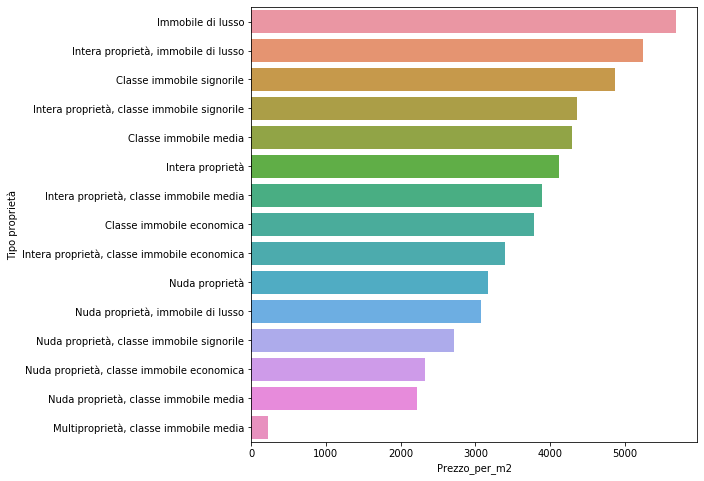

In [29]:
gb_ordered = (df.groupby('Tipo proprietà')
              .agg({'Prezzo_per_m2': 'mean'})
              .sort_values('Prezzo_per_m2', ascending=False))

fig = plt.figure(figsize=(8, 8))
sns.barplot(gb_ordered['Prezzo_per_m2'], y=gb_ordered.index, ci=None)
plt.show()

#### State

In [30]:
df['Stato'].isna().sum()

231

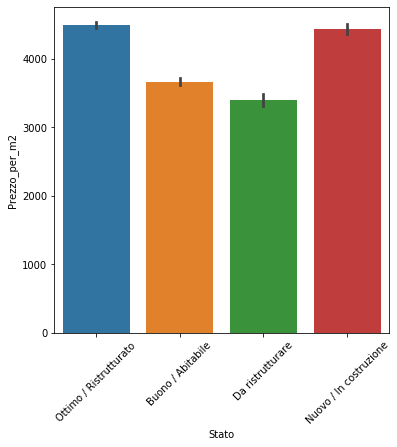

In [31]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Stato'], y=df['Prezzo_per_m2'])
plt.xticks(rotation=45)
plt.show()

In [32]:
df['Stato'].value_counts()

Ottimo / Ristrutturato    4514
Buono / Abitabile         2399
Nuovo / In costruzione     893
Da ristrutturare           677
Name: Stato, dtype: int64

In [33]:
# Imputing "Stato" by most frequent as it does not seem to influence price much
#df['Stato'] = df['Stato'].fillna(df['Stato'].value_counts().index[0])

#### Impute type of property and state using KNN

In [34]:
def encode(data):
    '''Function to encode non-null data and replace it in the original data'''
    
    # Retain only non-null values
    data = data.copy()
    non_nulls = np.array(data.dropna())
    
    # Reshape data for encoding
    impute_reshape = non_nulls.reshape(-1,1)
    
    # Encode data
    impute_ordinal = encoder.fit_transform(impute_reshape)
    
    # Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    
    return data

In [35]:
# Selecting features for KNN imputation
impute_cols = ['Prezzo_per_m2', 'Tipo proprietà', 'Stato']

df_impute = df[impute_cols].copy()

# Scaling continous feature used to impute
scaler = StandardScaler()

scale_cols = ['Prezzo_per_m2']
df_impute[scale_cols] = scaler.fit_transform(df_impute[scale_cols])

# Encoding and imputing
encoder = OrdinalEncoder()
imputer = KNNImputer(n_neighbors=5)

cat_cols = ['Tipo proprietà', 'Stato']

for col in cat_cols:
    # Encode categorical feature to impute
    df_impute[col] = encode(df_impute[col]).astype('float')
    
    # Impute using KNN
    df_impute[scale_cols+[col]] = np.round(imputer.fit_transform(df_impute[scale_cols+[col]]))

    # Inverse transform to get original labels back (for EDA later)
    df_impute[col] = encoder.inverse_transform(df_impute[col].to_numpy().reshape(-1,1))
    
df['Tipo_proprietà'] = df_impute['Tipo proprietà']
df['Stato'] = df_impute['Stato']

In [36]:
df = df.drop(columns=['Tipo proprietà'])

#### Contract

In [37]:
# Looking into "Contratto": does it affect price?
gb = df['Prezzo_per_m2'].groupby(df['Contratto']).agg('mean')
gb

Contratto
Vendita                         4137.211400
Vendita | Immobile a reddito    4668.302767
Name: Prezzo_per_m2, dtype: float64

#### Dropping features

In [38]:
# Drop columns that have almost no entries
# Dropping "Disponibilità" and "Contratto" because they do not have relevant information
drop_cols = ['Immobile garantito', 'Indice prest. energetica rinnovabile', 'Prestazione energetica del fabbricato',
             'Certificazione energetica', 'Disponibilità', 'Contratto', 'Informazioni catastali',
             'Spese condominio']

df[drop_cols].isna().sum()

Immobile garantito                       4999
Indice prest. energetica rinnovabile     8439
Prestazione energetica del fabbricato    8144
Certificazione energetica                7416
Disponibilità                             940
Contratto                                   0
Informazioni catastali                   3086
Spese condominio                         3595
dtype: int64

In [39]:
df = df.drop(columns=drop_cols)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8714 entries, 0 to 8713
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Riferimento e data annuncio  8714 non-null   object 
 1   Tipologia                    8714 non-null   object 
 2   Locali                       8701 non-null   object 
 3   Piano                        8560 non-null   object 
 4   Totale piani edificio        8082 non-null   object 
 5   Altre caratteristiche        8163 non-null   object 
 6   Posti auto                   2142 non-null   object 
 7   Zona                         8714 non-null   object 
 8   Anno di costruzione          6334 non-null   float64
 9   Stato                        8714 non-null   object 
 10  Riscaldamento                8320 non-null   object 
 11  Climatizzazione              4749 non-null   object 
 12  Efficienza energetica        7519 non-null   object 
 13  Prezzo_EUR        

## 2. Feature engineering

#### Heating

In [41]:
df['Riscaldamento'].isna().sum()

394

In [42]:
df['Riscaldamento'].unique()

array(['Autonomo, a radiatori, alimentato a metano',
       'Centralizzato, a radiatori, alimentato a metano',
       'Centralizzato, a radiatori, alimentato a gas',
       'Autonomo, a radiatori, alimentato a gas',
       'Centralizzato, a radiatori, alimentato a gasolio', 'Autonomo',
       'Centralizzato', 'Centralizzato, a radiatori', nan,
       'Autonomo, ad aria, alimentato a pompa di calore',
       'Autonomo, ad aria, alimentato a gas', 'Autonomo, a stufa',
       'Autonomo, a radiatori, alimentazione elettrica',
       'Autonomo, a radiatori', 'Autonomo, alimentato a gas',
       'Centralizzato, a pavimento, alimentato a fotovoltaico',
       'Centralizzato, a pavimento, alimentato a gas',
       'Centralizzato, a pavimento', 'Centralizzato, alimentato a metano',
       'Autonomo, ad aria',
       'Centralizzato, a pavimento, alimentato a metano',
       'Autonomo, a pavimento, alimentato a gas',
       'Centralizzato, a pavimento, alimentato a pompa di calore',
       'Auton

In [43]:
# Create autonomous/centralized heating feature
df['Riscaldamento_A_C'] = df['Riscaldamento'].str.split(',').str[0]

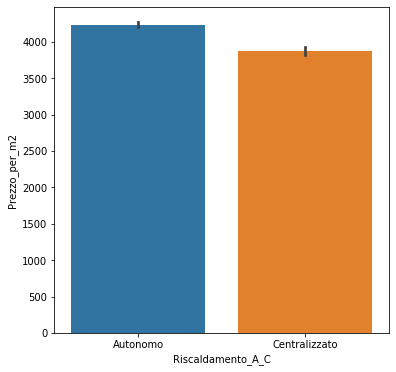

In [44]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Riscaldamento_A_C'], y=df['Prezzo_per_m2'])
plt.show()

In [45]:
df['Riscaldamento_A_C'].value_counts()

Autonomo         6488
Centralizzato    1832
Name: Riscaldamento_A_C, dtype: int64

In [46]:
# Filling heating NaNs with centralized because when not specified it is probably centralized
df['Riscaldamento_A_C'] = df['Riscaldamento_A_C'].fillna('Centralizzato')

In [47]:
# Create type of heating feature; clearly either radiatori, aria, pavimento and stufa
df['Tipo_riscaldamento'] = df['Riscaldamento'].str.extract(r'(radiatori|aria|pavimento|stufa)')

# Impute by most frequent
df['Tipo_riscaldamento'] = df['Tipo_riscaldamento'].fillna(df['Tipo_riscaldamento'].value_counts().index[0])
df['Tipo_riscaldamento'].value_counts()

radiatori    7931
aria          409
pavimento     355
stufa          19
Name: Tipo_riscaldamento, dtype: int64

In [48]:
df['Alimentazione_riscaldamento'] = df['Riscaldamento'].str.extract(r'(metano|gas|gasolio|pompa di calore'
                                                                    '|elettrica|fotovoltaico|pellet|gpl|solare)')

# Impute by most frequent
df['Alimentazione_riscaldamento'] = (df['Alimentazione_riscaldamento']
                                     .fillna(df['Alimentazione_riscaldamento'].value_counts().index[0]))

df['Alimentazione_riscaldamento'].value_counts()

metano             6700
gas                1581
pompa di calore     273
elettrica            81
gpl                  36
fotovoltaico         33
solare                7
pellet                3
Name: Alimentazione_riscaldamento, dtype: int64

In [49]:
df = df.drop(columns=['Riscaldamento'])

#### Air conditioning 

In [50]:
df['Climatizzazione'].value_counts()

Autonomo, freddo/caldo                    2151
Predisposizione impianto                  1031
Autonomo, freddo                           922
Autonomo                                   417
Centralizzato, freddo/caldo                 88
Predisposizione impianto, freddo            74
Centralizzato, freddo                       21
Predisposizione impianto, freddo/caldo      19
Centralizzato                               17
Autonomo, caldo                              9
Name: Climatizzazione, dtype: int64

In [51]:
# Too many missing values, going to drop from analysis
df['Climatizzazione'].isna().sum()

3965

In [52]:
df = df.drop(columns=['Climatizzazione'])

#### Energy efficiency

In [53]:
df['Efficienza energetica'].isna().sum()

1195

In [54]:
df['Efficienza energetica'].value_counts()

G ≥ 175 kWh/m² anno     2596
G 175,00 kWh/m² anno     606
G                        508
F ≥ 175 kWh/m² anno      302
G ≥ 3,51 kWh/m² anno     186
                        ... 
E 115,45 kWh/m² anno       1
G 175,20 kWh/m² anno       1
E 169,00 kWh/m² anno       1
G 77,12 kWh/m² anno        1
F 95,92 kWh/m² anno        1
Name: Efficienza energetica, Length: 1441, dtype: int64

In [55]:
# Map to letter categories of energy efficiency
df['Classe_energetica'] = df['Efficienza energetica'].str.extract(r'([A-G]\d?)')
df['Classe_energetica'].value_counts()

G     5542
F      785
E      331
A      201
B      176
D      160
C      125
A4     115
A1      34
A2      23
A3      13
Name: Classe_energetica, dtype: int64

In [56]:
(df.groupby('Alimentazione_riscaldamento')['Classe_energetica']
 .value_counts()
 .unstack()
 .apply(lambda x: x/x.sum()*100, axis=1))

Classe_energetica,A,A1,A2,A3,A4,B,C,D,E,F,G
Alimentazione_riscaldamento,,,,,,,,,,,
elettrica,5.333333,NaN,NaN,NaN,30.666667,10.666667,2.666667,6.666667,2.666667,10.666667,30.666667
fotovoltaico,32.142857,NaN,NaN,3.571429,57.142857,3.571429,3.571429,NaN,NaN,NaN,NaN
gas,1.438849,NaN,0.143885,0.071942,0.647482,1.726619,1.582734,1.438849,2.949640,9.424460,80.575540
gpl,NaN,NaN,NaN,NaN,NaN,5.714286,NaN,34.285714,2.857143,NaN,57.142857
metano,2.719665,0.557880,0.331241,0.174338,0.958856,2.039749,1.481869,1.970014,4.811715,10.896095,74.058577
pellet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,50.000000
pompa di calore,5.106383,0.851064,0.851064,0.425532,5.106383,9.361702,6.382979,4.255319,4.255319,8.510638,54.893617
solare,NaN,NaN,NaN,NaN,NaN,50.000000,NaN,NaN,25.000000,NaN,25.000000


In [57]:
# Impute by most frequent
df['Classe_energetica'] = df['Classe_energetica'].fillna(df['Classe_energetica'].value_counts().index[0])

df['Classe_energetica'].value_counts()

G     6751
F      785
E      331
A      201
B      176
D      160
C      125
A4     115
A1      34
A2      23
A3      13
Name: Classe_energetica, dtype: int64

In [58]:
df = df.drop(columns=['Efficienza energetica'])

#### Listing date

In [59]:
df['Riferimento e data annuncio'].head()

0       A0049 - 05/10/2020
1      alv275 - 05/10/2020
2    Novoli B - 05/10/2020
3    Novoli A - 05/10/2020
4     MAZZ328 - 05/10/2020
Name: Riferimento e data annuncio, dtype: object

In [60]:
df['Data_annuncio'] = (df['Riferimento e data annuncio']
                       .str.split('-')
                       .str[-1]
                       .str.strip()
                       .astype('datetime64[D]'))

In [61]:
df = df.drop(columns=['Riferimento e data annuncio'])

#### Floor

In [62]:
df['Piano'].unique()

array(['1° piano', '3° piano, con ascensore', '5° piano, con ascensore',
       'da seminterrato a 1°, con ascensore',
       'da seminterrato a piano terra, con ascensore, con accesso disabili',
       '3° piano', '2° piano', 'Piano terra', '1° piano, con ascensore',
       'Piano terra, con ascensore', 'Piano rialzato',
       'da 4° a 5°, con ascensore', '4° piano, con ascensore',
       'Piano rialzato, con ascensore', '6° piano, con ascensore',
       '2° piano, con ascensore, con accesso disabili', 'Seminterrato',
       'da piano terra a piano rialzato', '2° piano, con ascensore',
       'Piano rialzato, con ascensore, con accesso disabili',
       '1° piano, con ascensore, con accesso disabili',
       'Piano terra, con accesso disabili', '4° piano',
       '3° piano, con ascensore, con accesso disabili',
       'da 5° a 6°, con ascensore',
       '5° piano, con ascensore, con accesso disabili',
       '7° piano, con ascensore',
       '4°, con ascensore, con accesso disabili',

In [63]:
df['Piano'].value_counts().loc[df['Piano'].value_counts() > 50]

1° piano                                            1097
Piano terra                                          995
1° piano, con ascensore                              673
2° piano                                             635
3° piano                                             492
2° piano, con ascensore                              471
3° piano, con ascensore                              424
4° piano, con ascensore                              361
Piano terra, con accesso disabili                    273
Piano rialzato                                       254
Piano terra, con ascensore                           225
1° piano, con ascensore, con accesso disabili        194
Piano rialzato, con ascensore                        150
5° piano, con ascensore                              144
Ultimo piano                                         139
2° piano, con ascensore, con accesso disabili        125
4° piano                                             113
3° piano, con ascensore, con ac

In [64]:
# Create elevator feature
mask = df['Piano'].str.match(r'.*ascensore.*')

df['Ascensore'] = mask.astype('float')
df['Ascensore'] = df['Ascensore'].fillna(df['Ascensore'].value_counts().index[0])

In [65]:
df.loc[df['Piano'].isna(), :]

,Tipologia,Locali,Piano,Totale piani edificio,Altre caratteristiche,Posti auto,Zona,Anno di costruzione,Stato,Prezzo_EUR,Superficie_m2,Prezzo_per_m2,Tipo_proprietà,Riscaldamento_A_C,Tipo_riscaldamento,Alimentazione_riscaldamento,Classe_energetica,Data_annuncio,Ascensore
313,Terratetto unifamiliare,"5+ (3 camere da letto, 7 altri), 3 bagni, cuci...",NaN,NaN,Terrazza\n \n\n ...,NaN,Zona Bolognese Le Cure,NaN,Da ristrutturare,1095000.0,250.0,4380.000000,Classe immobile signorile,Autonomo,radiatori,metano,G,2020-02-10,0.0
321,Rustico,5 locali,NaN,NaN,NaN,NaN,Zona Firenze Sud,NaN,Buono / Abitabile,950000.0,250.0,3800.000000,"Intera proprietà, classe immobile economica",Centralizzato,radiatori,metano,G,2020-02-10,0.0
411,Appartamento,"4 (2 camere da letto, 2 altri), 1 bagno, cucin...",NaN,3 piani,NaN,NaN,Zona Firenze Sud,NaN,Buono / Abitabile,250000.0,70.0,3571.428571,"Intera proprietà, classe immobile economica",Centralizzato,radiatori,metano,G,2020-09-29,0.0
530,Appartamento,"2 (1 camera da letto, 1 altro), 1 bagno, cucin...",NaN,2 piani,Balcone,NaN,Leopoldo Porta Al Prato,NaN,Ottimo / Ristrutturato,185000.0,48.0,3854.166667,"Intera proprietà, classe immobile media",Autonomo,radiatori,metano,G,2020-02-10,0.0
533,Appartamento,"2 (1 camera da letto, 1 altro), 1 bagno, cucin...",NaN,2 piani,Balcone,NaN,Leopoldo Porta Al Prato,NaN,Ottimo / Ristrutturato,215000.0,52.0,4134.615385,"Intera proprietà, classe immobile media",Autonomo,radiatori,metano,G,2020-03-10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,Appartamento,"5+ (6 camere da letto, 6 altri), 3+ bagni, cuc...",NaN,NaN,Arredato,NaN,Centro,NaN,Ottimo / Ristrutturato,1400000.0,300.0,4666.666667,"Intera proprietà, classe immobile media",Autonomo,radiatori,metano,G,2018-01-29,0.0
8643,Appartamento,"5 (4 camere da letto, 1 altro), 2 bagni, cucin...",NaN,3 piani,Giardino comune,NaN,Campo Di Marte Liberta,NaN,Nuovo / In costruzione,650000.0,110.0,5909.090909,Intera proprietà,Autonomo,radiatori,metano,A,2018-05-03,0.0
8651,Appartamento,"4 (1 camera da letto, 3 altri), 2 bagni, cucin...",NaN,NaN,Giardino comune,NaN,Bellosguardo Galluzzo,NaN,Ottimo / Ristrutturato,1700000.0,200.0,8500.000000,"Intera proprietà, immobile di lusso",Autonomo,radiatori,metano,G,2016-08-09,0.0
8705,Appartamento,"5+ (4 camere da letto, 3 altri), 3+ bagni, cuc...",NaN,NaN,Cancello elettrico\n \n\n ...,"1 in garage/box, 5 all'esterno",Campo Di Marte Liberta,NaN,Nuovo / In costruzione,1700000.0,450.0,3777.777778,"Intera proprietà, classe immobile signorile",Centralizzato,radiatori,metano,G,2015-02-23,0.0


In [66]:
# Create access for disabled people feature
mask = df['Piano'].str.match(r'.*accesso disabili.*')

df['Accesso_disabili'] = mask.astype('float')
df['Accesso_disabili'] = df['Accesso_disabili'].fillna(df['Accesso_disabili'].value_counts().index[0])

df['Accesso_disabili'].value_counts()

0.0    7369
1.0    1345
Name: Accesso_disabili, dtype: int64

In [67]:
# Create multiple floors feature
mask1 = df['Piano'].str.match(r'.*\d+°.*').fillna(False)
mask2 = df['Piano'].str.match(r'.*[pP]iano terra.*').fillna(False)
mask3 = df['Piano'].str.match(r'[uU]ltimo.*').fillna(False)
mask4 = df['Piano'].str.match(r'[pP]iano rialzato.*').fillna(False)
mask5 = df['Piano'].str.match(r'.*[sS]eminterrato.*').fillna(False)
mask6 = df['Piano'].str.match(r'.*[aA]mmezzato.*').fillna(False)
mask7 = df['Piano'].str.match(r'.*[iI]nterrato.*').fillna(False)
mask8 = df['Piano'].str.match(r'(.*da.*|.*più livelli.*)').fillna(False)
mask9 = df['Piano'].str.match(r'.*Oltre il decimo piano.*').fillna(False)

df.loc[mask1, 'Piani'] = df.loc[mask1, 'Piano'].str.extract(r'(\d+°)').values
df.loc[mask2, 'Piani'] = 'terra'
df.loc[mask3, 'Piani'] = 'ultimo'
df.loc[mask4, 'Piani'] = 'rialzato'
df.loc[mask5, 'Piani'] = 'seminterrato'
df.loc[mask6, 'Piani'] = 'ammezzato'
df.loc[mask7, 'Piani'] = 'interrato'
df.loc[mask8, 'Piani'] = 'più livelli'
df.loc[mask9, 'Piani'] = 'oltre il decimo'

#df['Piu_livelli'] = df['Piu_livelli'].fillna(df['Piu_livelli'].value_counts().index[0])

df['Piani'].value_counts()

1°                 2114
terra              1598
2°                 1302
3°                 1086
4°                  594
più livelli         572
rialzato            508
ultimo              253
5°                  202
interrato           114
7°                   86
6°                   72
8°                   31
ammezzato            22
9°                    3
oltre il decimo       2
10°                   1
Name: Piani, dtype: int64

In [68]:
df.groupby('Tipologia')['Piani'].value_counts().unstack().apply(lambda x: x/x.sum()*100, axis=1)

Piani,10°,1°,2°,3°,4°,5°,6°,7°,8°,9°,ammezzato,interrato,oltre il decimo,più livelli,rialzato,terra,ultimo
Tipologia,,,,,,,,,,,,,,,,,
Appartamento,0.013371,27.156037,16.807060,13.825378,7.501003,2.032357,0.775505,0.909212,0.213932,0.026742,0.280786,1.350448,NaN,5.080893,5.802915,15.443241,2.781120
Appartamento in villa,NaN,44.827586,6.896552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.482759,NaN,13.793103,NaN
Attico,NaN,4.744526,8.029197,15.693431,11.678832,17.883212,5.109489,6.204380,5.474453,NaN,NaN,NaN,NaN,11.313869,NaN,0.729927,13.138686
Bed & Breakfast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
Casa colonica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.000000,15.000000,55.000000,NaN
Casale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.000000,20.000000,40.000000,NaN
Loft,NaN,29.090909,10.909091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.636364,NaN,5.454545,5.454545,45.454545,NaN
Mansarda,NaN,NaN,20.000000,20.000000,NaN,NaN,NaN,10.000000,NaN,10.000000,NaN,NaN,NaN,10.000000,NaN,NaN,30.000000
Open space,NaN,12.500000,12.500000,8.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.166667,NaN,4.166667,12.500000,16.666667,4.166667


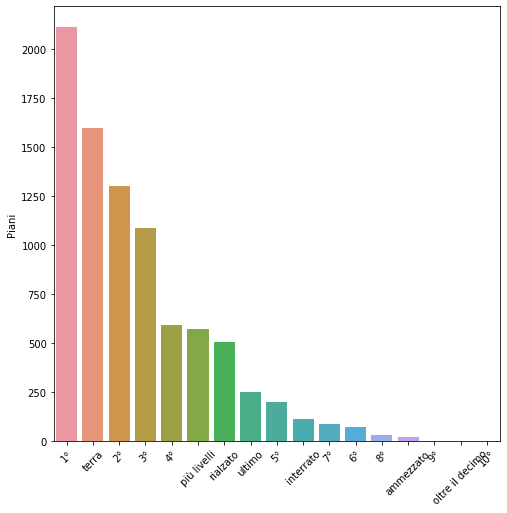

In [69]:
fig = plt.figure(figsize=(8, 8))
sns.barplot(x=df['Piani'].value_counts().index, y=df['Piani'].value_counts())
plt.xticks(rotation=45)
plt.show()

In [70]:
df['Piano'].isna().sum()

154

In [71]:
# We will simply impute by the most frequent for now
df['Piani'] = df['Piani'].fillna(df['Piani'].value_counts().index[0])

In [72]:
# Based on missing values and assuming this is not an important feature, we will surely drop it later
df.loc[df['Totale piani edificio'].isna(), :]

,Tipologia,Locali,Piano,Totale piani edificio,Altre caratteristiche,Posti auto,Zona,Anno di costruzione,Stato,Prezzo_EUR,Superficie_m2,Prezzo_per_m2,Tipo_proprietà,Riscaldamento_A_C,Tipo_riscaldamento,Alimentazione_riscaldamento,Classe_energetica,Data_annuncio,Ascensore,Accesso_disabili,Piani
10,Appartamento,"3 (2 camere da letto, 1 altro), 1 bagno, cucin...",1° piano,NaN,NaN,NaN,Legnaia Soffiano,NaN,Ottimo / Ristrutturato,183000.0,60.0,3050.000000,Intera proprietà,Autonomo,radiatori,metano,D,2020-05-10,0.0,0.0,1°
46,Appartamento,"3 (2 camere da letto, 1 altro), 2 bagni","4° piano, con ascensore",NaN,Cantina,NaN,Campo Di Marte Liberta,NaN,Ottimo / Ristrutturato,350000.0,85.0,4117.647059,Intera proprietà,Centralizzato,radiatori,metano,G,2020-05-10,1.0,0.0,4°
50,Appartamento,"4 (3 camere da letto, 1 altro), 2 bagni, cucin...","1° piano, con ascensore",NaN,Cantina\n \n\n ...,1 all'esterno,Zona Firenze Sud,NaN,Buono / Abitabile,397000.0,120.0,3308.333333,Intera proprietà,Autonomo,radiatori,metano,G,2020-05-10,1.0,0.0,1°
59,Appartamento,"3 locali, 1 bagno",1° piano,NaN,NaN,NaN,Zona Firenze Sud,NaN,Buono / Abitabile,265000.0,82.0,3231.707317,Intera proprietà,Centralizzato,radiatori,metano,G,2020-09-16,0.0,0.0,1°
60,Villa a schiera,"5+ (5 camere da letto, 4 altri), 3 bagni, cuci...",Piano terra,NaN,Giardino privato,1 in garage/box,Leopoldo Porta Al Prato,NaN,Buono / Abitabile,650000.0,200.0,3250.000000,Intera proprietà,Autonomo,radiatori,metano,G,2020-05-10,0.0,0.0,terra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8697,Appartamento,NaN,1° piano,NaN,NaN,NaN,Centro,1900.0,Ottimo / Ristrutturato,1200000.0,200.0,6000.000000,"Intera proprietà, classe immobile signorile",Centralizzato,radiatori,metano,G,2018-09-18,0.0,0.0,1°
8699,Appartamento,"5+ (5 camere da letto, 1 altro), 3+ bagni, cuc...","Piano rialzato, con ascensore",NaN,Caminetto\n \n\n ...,NaN,Campo Di Marte Liberta,NaN,Ottimo / Ristrutturato,690000.0,220.0,3136.363636,"Intera proprietà, classe immobile signorile",Autonomo,radiatori,metano,E,2020-11-02,1.0,0.0,rialzato
8705,Appartamento,"5+ (4 camere da letto, 3 altri), 3+ bagni, cuc...",NaN,NaN,Cancello elettrico\n \n\n ...,"1 in garage/box, 5 all'esterno",Campo Di Marte Liberta,NaN,Nuovo / In costruzione,1700000.0,450.0,3777.777778,"Intera proprietà, classe immobile signorile",Centralizzato,radiatori,metano,G,2015-02-23,0.0,0.0,1°
8710,Villa unifamiliare,"5 locali, 3+ bagni, cucina abitabile",NaN,NaN,Terrazza\n \n\n ...,1 all'esterno,Zona Bolognese Le Cure,NaN,Buono / Abitabile,2500000.0,340.0,7352.941176,"Intera proprietà, classe immobile economica",Autonomo,radiatori,metano,G,2016-08-24,0.0,0.0,1°


In [73]:
df = df.drop(columns=['Piano', 'Totale piani edificio'])
df = df.rename(columns={'Piani': 'Piano'})

#### Car parking

In [74]:
df['Posti auto'].unique()

array([nan, "1 all'esterno", "2 all'esterno", '1 in garage/box',
       "6 all'esterno", "3 all'esterno", '2 in garage/box',
       "1 in garage/box, 1 all'esterno", "4 all'esterno", "5 all'esterno",
       "2 in garage/box, 2 all'esterno", "2 in garage/box, 8 all'esterno",
       "1 in garage/box, 2 all'esterno", "2 in garage/box, 1 all'esterno",
       "10 all'esterno", "1 in garage/box, 3 all'esterno",
       "176 all'esterno", "2 in garage/box, 10 all'esterno",
       "2 in garage/box, 5 all'esterno", "2 in garage/box, 6 all'esterno",
       "9 all'esterno", "1 in garage/box, 4 all'esterno",
       "1 in garage/box, 6 all'esterno", "7 all'esterno",
       "1 in garage/box, 5 all'esterno", "20 all'esterno",
       "2 in garage/box, 20 all'esterno",
       "2 in garage/box, 3 all'esterno",
       "1 in garage/box, 14 all'esterno",
       "2 in garage/box, 4 all'esterno", "1 in garage/box, 7 all'esterno",
       "8 all'esterno", "2 in garage/box, 7 all'esterno",
       "2 in garage/bo

In [75]:
# Consider NaNs as no parkings
df['Posti auto'].isna().sum()

6572

In [76]:
# Garage car parking
df['Posti_garage'] = df['Posti auto'].str.extract(r'(\d).*garage\/box').astype('float')

df['Posti_garage'] = df['Posti_garage'].fillna(0)
df['Posti_garage'].value_counts()

0.0    7830
1.0     671
2.0     213
Name: Posti_garage, dtype: int64

In [77]:
# External car parking
df['Posti_esterni'] = df['Posti auto'].str.extract(r'(\d+).*esterno').astype('float')

df['Posti_esterni'] = df['Posti_esterni'].fillna(0)
df['Posti_esterni'].value_counts()

0.0      7056
1.0      1203
2.0       347
3.0        43
4.0        27
5.0        11
10.0        9
6.0         7
8.0         4
20.0        3
7.0         2
9.0         1
176.0       1
Name: Posti_esterni, dtype: int64

In [78]:
df = df.drop(columns=['Posti auto'])

#### Number of toilets

In [79]:
# Toilets
df['Num_bagni'] = df['Locali'].str.extract(r'(\d\+?) bagn\w')
df['Num_bagni'] = df['Num_bagni'].fillna(0)
df.loc[df['Num_bagni'] == '3+', 'Num_bagni'] = 4 # Set 3+ toilets to 4
df['Num_bagni'] = df['Num_bagni'].astype('float')

df['Num_bagni'].value_counts()

1.0    4415
2.0    2986
3.0     772
4.0     436
0.0     105
Name: Num_bagni, dtype: int64

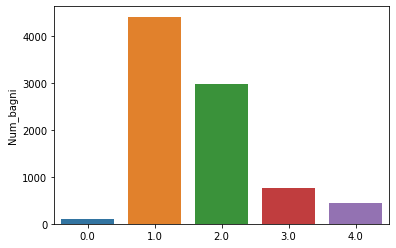

In [80]:
sns.barplot(x=df['Num_bagni'].value_counts().index, y=df['Num_bagni'].value_counts())
plt.show()

In [81]:
df.loc[df['Num_bagni'] == 0, 'Superficie_m2']

97      120.0
117     500.0
321     250.0
401      95.0
433     200.0
        ...  
8342    350.0
8431     58.0
8448     21.0
8625    172.0
8697    200.0
Name: Superficie_m2, Length: 105, dtype: float64

In [82]:
# Create area bins for imputing
df['Superficie_bins'] = pd.cut(df['Superficie_m2'], bins=[0, 60, 80, 100, 120, 160, 200, 20000])

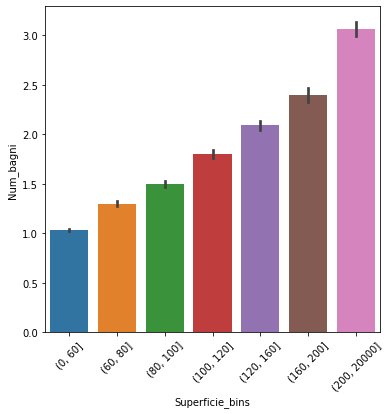

In [83]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_bins'], y=df['Num_bagni'])
plt.xticks(rotation=45)
plt.show()

In [84]:
df.groupby('Superficie_bins')['Num_bagni'].agg(lambda x:x.value_counts().index[0])

Superficie_bins
(0, 60]         1.0
(60, 80]        1.0
(80, 100]       1.0
(100, 120]      2.0
(120, 160]      2.0
(160, 200]      2.0
(200, 20000]    4.0
Name: Num_bagni, dtype: float64

In [85]:
# Imputing number of toilets based on area bins
for area in df['Superficie_bins'].unique():
    mask = df['Superficie_bins'] == area
    df.loc[mask & (df['Num_bagni'] == 0), 'Num_bagni'] = df.loc[mask, 'Num_bagni'].value_counts().index[0]

#### Number of rooms

In [86]:
# Other rooms
df['Num_altri'] = df['Locali'].str.extract(r'(\d+\+?) altr\w').astype('float')
df['Num_altri'] = df['Num_altri'].fillna(0) # Set NaNs to 0 to be able to sum

df['Num_camere_letto'] = df['Locali'].str.extract(r'(\d+\+?) camer\w da letto').astype('float')
df['Num_camere_letto'] = df['Num_camere_letto'].fillna(0)# Set NaNs to 0 to be able to sum

df['Num_locali'] = df['Locali'].str.extract(r'(\d+\+?) local\w').astype('float')
df['Num_locali'] = df['Num_locali'].fillna(0) # Set NaNs to 0 to be able to sum

# Total number of rooms
df['Num_tot_locali'] = df['Num_locali'] + df['Num_camere_letto'] + df['Num_altri']

In [87]:
df['Locali'].isna().sum()

13

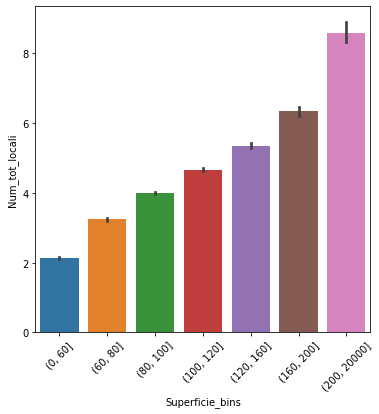

In [88]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_bins'], y=df['Num_tot_locali'])
plt.xticks(rotation=45)
plt.show()

In [89]:
# Imputing total number of rooms based on area bins
for area in df['Superficie_bins'].unique():
    mask = df['Superficie_bins'] == area
    df.loc[mask & (df['Num_tot_locali'] == 0), 'Num_tot_locali'] = df.loc[mask, 'Num_tot_locali'].value_counts().index[0]

In [90]:
df['Num_tot_locali'].isna().sum()

0

In [91]:
df = df.drop(columns=['Locali', 'Num_altri', 'Num_camere_letto', 'Num_locali'])

#### Year of construction

In [92]:
df['Anno di costruzione'].value_counts().head()

1970.0    885
1900.0    821
1960.0    729
1800.0    475
1950.0    427
Name: Anno di costruzione, dtype: int64

In [93]:
test = pd.cut(df['Anno di costruzione'], bins=[0, 1900, 1950, 1980, 2000, 2010, 2020])

In [94]:
df.loc[df['Anno di costruzione'].isna(), 'Stato'].value_counts()

Ottimo / Ristrutturato    1399
Buono / Abitabile          587
Nuovo / In costruzione     246
Da ristrutturare           148
Name: Stato, dtype: int64

In [95]:
df['Anno di costruzione'].isna().sum()

2380

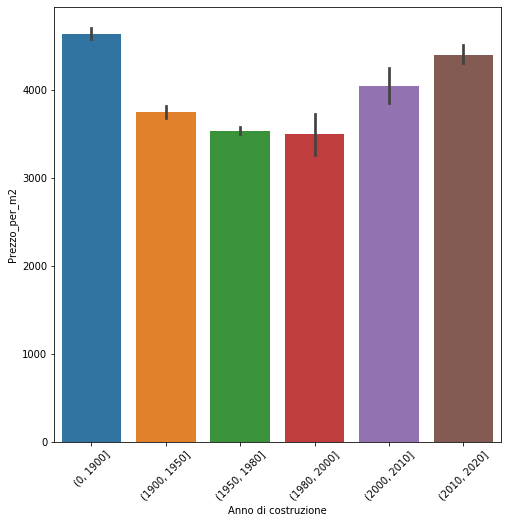

In [96]:
fig = plt.figure(figsize=(8, 8))
sns.barplot(x=test, y=df['Prezzo_per_m2'])
plt.xticks(rotation=45)
plt.show()

In [97]:
# Impute year of construction using KNN algorithm

# Selecting features for KNN imputation
impute_cols = ['Prezzo_per_m2', 'Anno di costruzione']

df_impute = df[impute_cols].copy()

# Scaling continous feature used to impute
scaler = StandardScaler()

df_impute[impute_cols] = scaler.fit_transform(df_impute[impute_cols])

# Impute using KNN
imputer = KNNImputer(n_neighbors=5)

df_impute[impute_cols] = imputer.fit_transform(df_impute[impute_cols])

# Inverse transform to get the year back
df_impute[impute_cols] = np.floor(scaler.inverse_transform(df_impute[impute_cols]))
df['Anno_costruzione'] = df_impute['Anno di costruzione']
df['Anno_costruzione'].value_counts()

1970.0    899
1900.0    834
1960.0    741
1800.0    479
1950.0    453
         ... 
1838.0      1
1845.0      1
1590.0      1
1686.0      1
1650.0      1
Name: Anno_costruzione, Length: 331, dtype: int64

In [98]:
df.loc[df['Anno_costruzione'] == 2021.0, 'Anno_costruzione'] = 2020
df = df.drop(columns=['Anno di costruzione'])

In [108]:
df['Anno_costruzione'].mean()

1886.6147578609134

#### Other characteristics

In [99]:
df['Altre caratteristiche'].unique()

array(['Fibra ottica\n                \n\n                    VideoCitofono\n                \n\n                    Porta blindata\n                \n\n                    Impianto tv singolo\n                \n\n                    Parzialmente Arredato\n                \n\n                    Infissi esterni in vetro / legno\n                \n\n                    Esposizione doppia',
       'Fibra ottica\n                \n\n                    Porta blindata\n                \n\n                    Balcone\n                \n\n                    Impianto tv centralizzato\n                \n\n                    Infissi esterni in doppio vetro / PVC\n                \n\n                    Esposizione doppia',
       'Porta blindata\n                \n\n                    Esposizione esterna\n                \n\n                    Terrazza\n                \n\n                    Impianto tv singolo\n                \n\n                    Infissi esterni in doppio vetro / PVC'

In [100]:
def string_parser(row):
    if pd.notnull(row['Altre caratteristiche']):
        string_list = row['Altre caratteristiche'].split('\n')
        row['Altre_caratteristiche'] = [string.strip() for string in string_list if string.strip() != '']
    
    else:
        row['Altre_caratteristiche'] = []
    
    return row['Altre_caratteristiche']

In [101]:
df['Altre_caratteristiche'] = df['Altre caratteristiche'].copy()
df['Altre_caratteristiche'] = df.apply(string_parser, axis=1)

In [102]:
# Determine all characteristics
def unique(df):
    unique_list = []

    for idx, series in df.iterrows():
        for characteristic in series.loc['Altre_caratteristiche']:
            if characteristic not in unique_list:
                unique_list.append(characteristic)
        else:
            continue
   
    return unique_list

In [103]:
unique_list = unique(df)
unique_list

['Fibra ottica',
 'VideoCitofono',
 'Porta blindata',
 'Impianto tv singolo',
 'Parzialmente Arredato',
 'Infissi esterni in vetro / legno',
 'Esposizione doppia',
 'Balcone',
 'Impianto tv centralizzato',
 'Infissi esterni in doppio vetro / PVC',
 'Esposizione esterna',
 'Terrazza',
 'Cancello elettrico',
 'Cantina',
 'Giardino privato',
 'Caminetto',
 'Portiere intera giornata',
 'Infissi esterni in doppio vetro / legno',
 'Armadio a muro',
 'Impianto di allarme',
 'Mansarda',
 'Infissi esterni in doppio vetro / metallo',
 'Solo Cucina Arredata',
 'Esposizione interna',
 'Infissi esterni in vetro / PVC',
 'Giardino comune',
 'Taverna',
 'Impianto tv con parabola satellitare',
 'Arredato',
 'Infissi esterni in triplo vetro / PVC',
 'Infissi esterni in triplo vetro / legno',
 'Infissi esterni in vetro / metallo',
 'Portiere mezza giornata',
 'Cablato',
 'Idromassaggio',
 'Reception',
 'Piscina',
 'Infissi esterni in triplo vetro / metallo']

In [104]:
# Create one-hot encoded feature for each characteristic
for characteristic in unique_list:
    mask = df['Altre_caratteristiche'].apply(lambda x: characteristic in x)
    df[characteristic] = mask.astype('float')

In [105]:
df = df.drop(columns=['Altre caratteristiche', 'Altre_caratteristiche'])

### 3. Exporting DataFrame

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8714 entries, 0 to 8713
Data columns (total 59 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Tipologia                                  8714 non-null   object        
 1   Zona                                       8714 non-null   object        
 2   Stato                                      8714 non-null   object        
 3   Prezzo_EUR                                 8714 non-null   float64       
 4   Superficie_m2                              8714 non-null   float64       
 5   Prezzo_per_m2                              8714 non-null   float64       
 6   Tipo_proprietà                             8714 non-null   object        
 7   Riscaldamento_A_C                          8714 non-null   object        
 8   Tipo_riscaldamento                         8714 non-null   object        
 9   Alimentazione_risca

In [107]:
df.to_excel(path_interim+'data.xlsx', index=False)